# ATML2021 Assignment 3 Nalet Meinen

In [1]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as TF
import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import PIL.Image as Image
import pandas as pd
import random

import torchvision.utils as vutils

In [2]:
!nvidia-smi

Mon May 24 17:16:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.118.02   Driver Version: 440.118.02   CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   48C    P8    15W / 250W |   2458MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 44%   58C    P8    17W / 250W |     10MiB / 11175MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

Here we implement the dataset class, create the training, validation and test sets and the dataloaders.

In [3]:
class LabeledDataset(Dataset):
    def __init__(self, folder_path, phase='train', transform=None):
        super(LabeledDataset, self).__init__()
        self.phase = phase
        if self.phase == 'train':
            file_path = os.path.join(folder_path, 'train_32x32_500_label.npz')
        elif self.phase == 'val':
            file_path = os.path.join(folder_path, 'test_32x32_2000_label.npz')
        elif self.phase == 'test':
            file_path = os.path.join(folder_path, 'test_32x32_competition.npy')
        elif self.phase == 'unlabel':
            file_path = os.path.join(folder_path, 'train_32x32_unlabel.npy')
        else:
            print('Unrecognized phase')
        data_load = np.load(file_path)
        
        if self.phase != 'test' and self.phase != 'unlabel':
            self.dataset = data_load['img']
            self.labels = data_load['label'].astype('int64')
        else:
            self.dataset = data_load
            
        self.transform = transform
        
    def __getitem__(self, index): 
        img_index = Image.fromarray(self.dataset[index,:])
        if self.phase != 'test':
            return self.transform(img_index), self.labels[index,0]
        else:
            return self.transform(img_index)

    def __len__(self):
        return self.dataset.shape[0]

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([ transforms.ToTensor(),
                               transforms.Normalize((0.4380, 0.4440, 0.4730), (0.1751, 0.1771, 0.1744))
                             ])

transform_train=transforms.Compose([ transforms.RandomChoice([
                                         transforms.RandomResizedCrop(32,scale=(0.85, 1.0), ratio=(0.9, 1.1)),
                                         transforms.RandomRotation([-7,7]),
                                         torchvision.transforms.ColorJitter()
                                     ]),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.4380, 0.4440, 0.4730), (0.1751, 0.1771, 0.1744))
                             ])

train_set = LabeledDataset('.', phase='train', transform=transform_train)
val_set = LabeledDataset('.', phase='val', transform=transform)
test_set = LabeledDataset('.', phase='test', transform=transform)
unlabel_set = LabeledDataset('.', phase='unlabel', transform=transform)

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)
unlabel_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)


#Here we concat the dataset multiple time to have more images (augumentation)
train_set_2 = LabeledDataset('.', phase='train', transform=transform_train)

for _ in range(7):
    train_set_2 = torch.utils.data.ConcatDataset([train_set_2, train_set_2])

train_loader_2 = DataLoader(train_set_2, batch_size=batch_size, shuffle=True, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 7
Image shape: torch.Size([3, 32, 32])


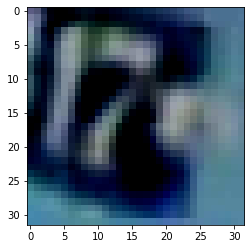

In [5]:
sample_image = train_set[0]
plt.imshow(sample_image[0].permute(1,2,0)*0.5 + 0.5)
print("Label:", sample_image[1])
print("Image shape:", sample_image[0].shape)

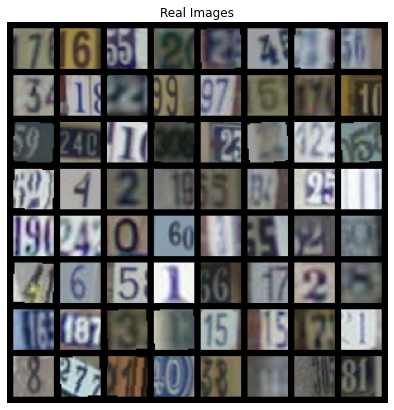

In [6]:
real_batch = next(iter(unlabel_loader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

Let us define a fully-convolutional classifier.

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(128, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 3, 4, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, num_classes=10):
        super(Discriminator, self).__init__()
        self.layer01 = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer02 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer03 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.layer04 = nn.Sequential(
            nn.Conv2d(256, 1024, 4, 2, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        self.layer05 = nn.Sequential(
            nn.Conv2d(1024, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, img):
        output = self.layer01(img)
        output = self.layer02(output)
        output = self.layer03(output)
        output = self.layer04(output)
        output = self.layer05(output)
        return output.squeeze(3).squeeze(2)

class ClassifierNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ClassifierNet, self).__init__()
        self.layer01 = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer02 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer03 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.layer04 = nn.Sequential(
            nn.Conv2d(256, 1024, 4, 2, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        
        self.layer05 = nn.Sequential(
            nn.Conv2d(1024, 512, 2, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.classification_head = nn.Sequential(
            nn.Conv2d(512, num_classes, 2, 1, 0),
        )
        
    def forward(self, img):
        output = self.layer01(img)
        output = self.layer02(output)
        output = self.layer03(output)
        output = self.layer04(output)
        output = self.layer05(output)
        output = self.classification_head(output)
        return output.squeeze(3).squeeze(2)
    
print(Generator())
print(Discriminator())
print(ClassifierNet())

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [8]:
model = ClassifierNet().to(device)

noise = torch.randn(4, 3, 32, 32, device=device)
out = model(noise)
print("Model output shape:", out.size())

Model output shape: torch.Size([4, 10])


Define the criterion and the optimizer.

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),  lr=0.001)

Train the model for 20 epochs.

In [10]:
for epoch in tqdm(range(30)):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))
            running_loss = 0.0

  0%|          | 0/30 [00:00<?, ?it/s]

Test the model on the validation set.

In [11]:
correct = 0
total = 0
total_loss = 0
with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
            
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_loss += loss.item()

print('Accuracy of the network on the 2000 validation images: %d %%' % (
    100 * correct / total))
print('Val loss', total_loss / len(val_loader))

Accuracy of the network on the 2000 validation images: 58 %
Val loss 2.147417549043894


In [12]:
# Number of training epochs
num_epochs = 1200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, 128, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

img_list = []
G_losses = []
D_losses = []
iters = 0

pbar = tqdm(range(num_epochs))
for epoch in pbar:
    for i, data in enumerate(unlabel_loader):
        # maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 128, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        pbar.set_description('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                            % (i, len(unlabel_loader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
    
        iters += 1

    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
torch.save(netD.state_dict(), "unsuperviced_pre-training.pht")

  0%|          | 0/750 [00:00<?, ?it/s]

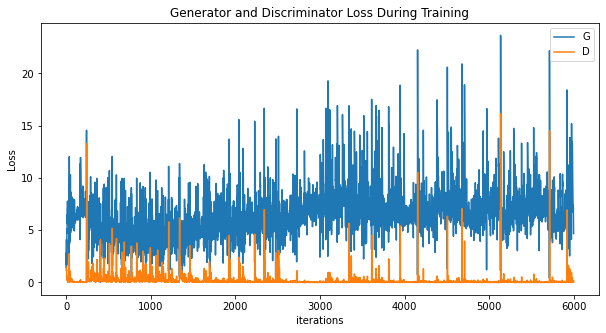

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

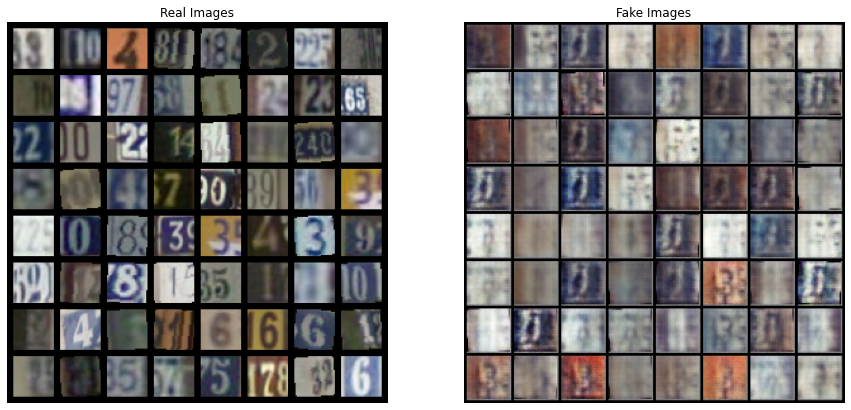

In [14]:
real_batch = next(iter(unlabel_loader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [15]:
def train(model, train_loader, optimizer, loss_fn):
    '''
    Trains the model for one epoch
    '''
    model.train()
    losses = []
    n_correct = 0
    for iteration, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        optimizer.zero_grad()
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        n_correct += torch.sum(output.argmax(1) == labels).item()
    accuracy = 100.0 * n_correct / len(train_loader.dataset)
    return np.mean(np.array(losses)), accuracy
            
def test(model, test_loader, loss_fn):
    '''
    Tests the model on data from test_loader
    '''
    model.eval()
    test_loss = 0
    n_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            test_loss += loss.item()
            n_correct += torch.sum(output.argmax(1) == labels).item()

    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
    return average_loss, accuracy


def fit(taskname,train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs):

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    last_val_accuracies = 0
    best_epoch = 1

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
        val_loss, val_accuracy = test(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print("""Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}""".format(
                        epoch+1, n_epochs, train_losses[-1], train_accuracies[-1], val_losses[-1], val_accuracies[-1]))

        if val_accuracies[-1] > last_val_accuracies:
            torch.save(model.state_dict(), str(taskname)+".pht")
            best_epoch = epoch+1
            last_val_accuracies = val_accuracies[-1]

    best_model = ClassifierNet()
    best_model = best_model.to(device)
    best_model.load_state_dict(torch.load(str(taskname)+".pht"))

    return train_losses, train_accuracies, val_losses, val_accuracies, loss_fn, best_model, best_epoch

def plot_results(train_results, test_dataloader, val_dataloader):
    train_losses, train_accuracies, val_losses, val_accuracies, loss_fn, best_model, best_epoch = train_results

    fig, axs = plt.subplots(1, 2, figsize=(15, 4))

    axs[0].plot(np.arange(len(train_losses)), train_losses)
    axs[0].plot(np.arange(len(val_losses)), val_losses)
    axs[0].legend(['train_loss', 'val_loss'])
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss value')
    axs[0].set_title('Train/val loss')

    axs[1].plot(np.arange(len(train_accuracies)), train_accuracies)
    axs[1].plot(np.arange(len(val_accuracies)), val_accuracies)
    axs[1].legend(['train_acc', 'val_acc'])
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].set_title('Train/val accuracy')

    plt.show()

    m_loss, accuracy = test(best_model, val_dataloader, loss_fn)
    print("Best Epoch:", best_epoch, "Average loss:", m_loss, "Accuracy:", accuracy)
    torch.cuda.empty_cache()

def test_pretrained(taskname,num_blocks,val_dataloader,loss_fn):
    best_model = ClassifierNet(num_blocks)
    best_model = best_model.to(device)
    best_model.load_state_dict(torch.load(str(taskname)+".pht"))
    m_loss, accuracy = test(best_model, val_dataloader, loss_fn)
    print("Model:", taskname, "Average loss:", m_loss, "Accuracy:", accuracy)

def show_validation_errors(taskname,num_blocks,test_loader,num_images=10):
    model = ClassifierNet(num_blocks)
    model = model.to(device)
    model.load_state_dict(torch.load(str(taskname)+".pht"))

    model.eval()
    images_so_far = 0
    fig = plt.figure()

    def imshow(inp, title=None):
        """Imshow for Tensor."""
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array(_t_mean)
        std = np.array(_t_std)
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.figure(figsize=(5,5))
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            _, preds = torch.max(output, 1)
            
            for j in range(images.size()[0]):
                if(labels.cpu().data[j] == preds[j]):
                    continue
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('actual: {}, predicted: {}'.format(labels.cpu().data[j], preds[j]))
                imshow(images.cpu().data[j])

                if images_so_far == num_images:
                    return

    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
    return average_loss, accuracy

In [16]:
def get_transfer_model(): 
    #Preparations
    pretrained_model = Discriminator()
    pretrained_model = pretrained_model.to(device)
    pretrained_model.load_state_dict(torch.load("unsuperviced_pre-training.pht"))

    #Transfer
    transfer_model = ClassifierNet()
    transfer_model.layer01 = pretrained_model.layer01
    transfer_model.layer02 = pretrained_model.layer02
    transfer_model.layer03 = pretrained_model.layer03
    transfer_model.layer04 = pretrained_model.layer04
    return transfer_model

n_epochs = 50
lr = 0.0001
loss_fn = nn.CrossEntropyLoss()

Epoch 1/50: train_loss: 0.0837, train_accuracy: 97.8891, val_loss: 1.8525, val_accuracy: 53.9000
Epoch 2/50: train_loss: 0.0046, train_accuracy: 99.9016, val_loss: 1.8528, val_accuracy: 56.2500
Epoch 3/50: train_loss: 0.0029, train_accuracy: 99.9297, val_loss: 1.8506, val_accuracy: 59.0000
Epoch 4/50: train_loss: 0.0002, train_accuracy: 100.0000, val_loss: 1.9243, val_accuracy: 58.3500
Epoch 5/50: train_loss: 0.0059, train_accuracy: 99.8312, val_loss: 2.0781, val_accuracy: 59.2000
Epoch 6/50: train_loss: 0.0002, train_accuracy: 100.0000, val_loss: 2.0891, val_accuracy: 59.9000
Epoch 7/50: train_loss: 0.0002, train_accuracy: 99.9969, val_loss: 2.0538, val_accuracy: 60.7500
Epoch 8/50: train_loss: 0.0000, train_accuracy: 100.0000, val_loss: 2.0303, val_accuracy: 61.5000
Epoch 9/50: train_loss: 0.0073, train_accuracy: 99.8391, val_loss: 1.7963, val_accuracy: 62.9000
Epoch 10/50: train_loss: 0.0016, train_accuracy: 99.9594, val_loss: 1.9348, val_accuracy: 62.9500
Epoch 11/50: train_loss: 0

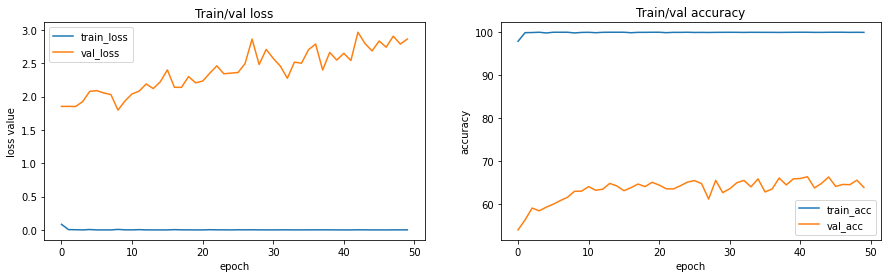

Best Epoch: 42 Average loss: 2.541138969361782 Accuracy: 66.3
CPU times: user 9min 21s, sys: 1min 28s, total: 10min 50s
Wall time: 10min 54s


In [17]:
%%time
model = ClassifierNet()
model = model.to(device)
model.load_state_dict(get_transfer_model().state_dict())

model.layer01.requires_grad = False
model.layer02.requires_grad = False
model.layer03.requires_grad = False
model.layer04.requires_grad = False

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_features_results = fit("fixed_features", train_loader_2, val_loader, model, optimizer, loss_fn, n_epochs)
plot_results(fixed_features_results, train_loader_2, val_loader)

Epoch 1/50: train_loss: 0.0821, train_accuracy: 97.9562, val_loss: 1.7771, val_accuracy: 55.6000
Epoch 2/50: train_loss: 0.0066, train_accuracy: 99.8312, val_loss: 1.8198, val_accuracy: 58.6000
Epoch 3/50: train_loss: 0.0014, train_accuracy: 99.9719, val_loss: 1.9987, val_accuracy: 55.7000
Epoch 4/50: train_loss: 0.0029, train_accuracy: 99.9375, val_loss: 2.1008, val_accuracy: 57.8000
Epoch 5/50: train_loss: 0.0039, train_accuracy: 99.8984, val_loss: 2.0164, val_accuracy: 60.3500
Epoch 6/50: train_loss: 0.0020, train_accuracy: 99.9469, val_loss: 2.0093, val_accuracy: 60.6500
Epoch 7/50: train_loss: 0.0003, train_accuracy: 99.9953, val_loss: 1.9068, val_accuracy: 63.2000
Epoch 8/50: train_loss: 0.0039, train_accuracy: 99.9062, val_loss: 1.9692, val_accuracy: 63.7000
Epoch 9/50: train_loss: 0.0015, train_accuracy: 99.9625, val_loss: 2.0966, val_accuracy: 62.2000
Epoch 10/50: train_loss: 0.0001, train_accuracy: 100.0000, val_loss: 2.1826, val_accuracy: 61.6500
Epoch 11/50: train_loss: 0.0

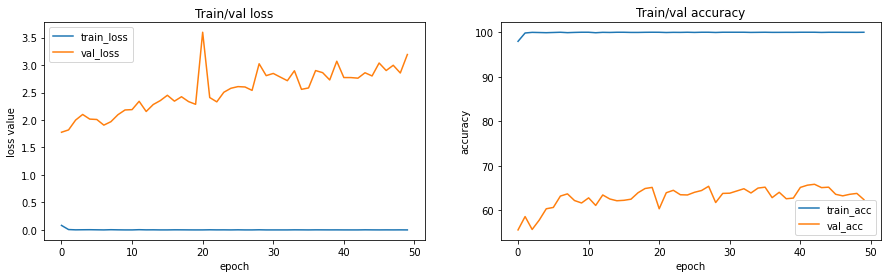

Best Epoch: 43 Average loss: 2.7614608854055405 Accuracy: 65.85
CPU times: user 9min 20s, sys: 1min 31s, total: 10min 51s
Wall time: 10min 58s


In [18]:
%%time
#Preparations
model = ClassifierNet()
model = model.to(device)
model.load_state_dict(get_transfer_model().state_dict())

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_features_results = fit("finetuned_features", train_loader_2, val_loader, model, optimizer, loss_fn, n_epochs)
plot_results(fixed_features_results, train_loader_2, val_loader)

We expect similar accuracy on the leaderboard. However, the overfitting is clear. Let us prepare the submission file.

In [19]:
predictions = np.array([])

with torch.no_grad():
    for data in test_loader:
        inputs = data
        inputs = inputs.to(device)
        
        outputs = model(inputs)
            
        _, predicted = torch.max(outputs.data, 1)
        predictions = np.append(predictions, predicted.cpu())

In [20]:
predictions = pd.DataFrame({
    "Id": np.arange(predictions.size),
    "Category": predictions},
    dtype=np.int64)

In [21]:
predictions.to_csv("baseline_predictions.csv", index=False)